# Bills of Mortality - Temporal Analysis

This notebook focuses on temporal patterns in the Bills of Mortality data, including:
- Long-term mortality trends
- Seasonal patterns
- Crisis periods and epidemics
- Weekly and yearly variations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
warnings.filterwarnings('ignore')

# Data directory
DATA_DIR = Path('../data')

print("📈 Bills of Mortality - Temporal Analysis")
print("="*45)

📈 Bills of Mortality - Temporal Analysis


## Load and Prepare Data

In [6]:
# Load datasets
bills = pd.read_csv(DATA_DIR / 'all_bills.csv')
parishes = pd.read_csv(DATA_DIR / 'parishes.csv')
years = pd.read_csv(DATA_DIR / 'years.csv')
weeks = pd.read_csv(DATA_DIR / 'weeks.csv')

print(f"Loaded {len(bills):,} bill records")
print(f"Time range: {bills['year'].min()} - {bills['year'].max()}")
print(f"Parishes: {bills['parish_id'].nunique()}")
print(f"Count types: {bills['count_type'].unique()}")
print(f"Bill types: {bills['bill_type'].unique()}")

# Create parish name mapping
parish_map = parishes.set_index('id')['parish_name'].to_dict()

# Prepare time-series data
bills['parish_name'] = bills['parish_id'].map(parish_map)

# Extract week information from week_id if possible
if bills['week_id'].str.contains('-').any():
    week_parts = bills['week_id'].str.split('-', expand=True)
    if len(week_parts.columns) >= 3:
        bills['week_num'] = pd.to_numeric(week_parts.iloc[:, -1], errors='coerce')
        bills['season'] = bills['week_num'].apply(lambda x: 
            'Winter' if x in [1,2,3,4,5,6,50,51,52] 
            else 'Spring' if x in [7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
            else 'Summer' if x in [21,22,23,24,25,26,27,28,29,30,31,32,33,34] 
            else 'Autumn' if x in [35,36,37,38,39,40,41,42,43,44,45,46,47,48,49] 
            else 'Unknown')

print(f"\n✓ Data preparation complete")

Loaded 1,292,566 bill records
Time range: 1635 - 1752
Parishes: 149
Count types: ['buried' 'plague']
Bill types: ['weekly' 'general']

✓ Data preparation complete


## Long-term Mortality Trends

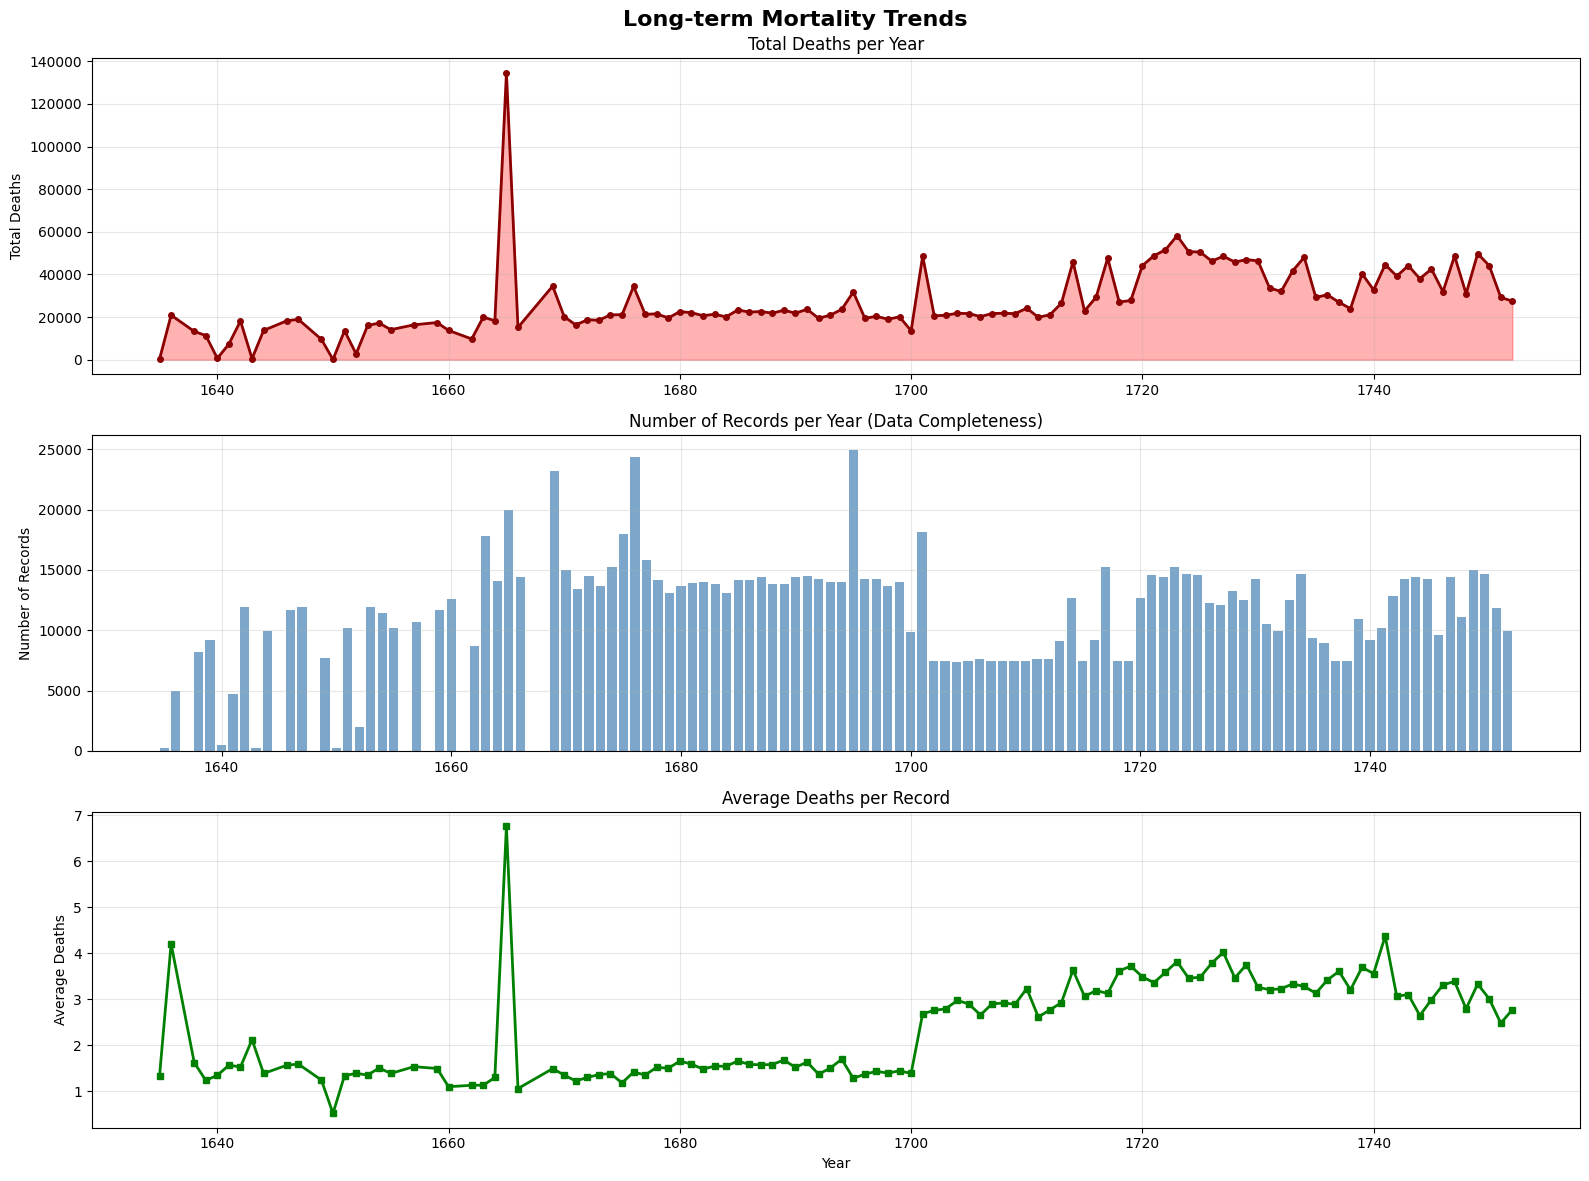


⚠️ Crisis Years (>90th percentile mortality):
  1665: 134,659 deaths
  1701: 48,645 deaths
  1721: 48,806 deaths
  1722: 51,578 deaths
  1723: 58,198 deaths
  1724: 50,718 deaths
  1725: 50,523 deaths
  1727: 48,562 deaths
  1734: 48,075 deaths
  1747: 48,691 deaths
  1749: 49,812 deaths

📈 Biggest Year-over-Year Increases:
  1651.0: +10541.4% (13,621.0 deaths)
  1636.0: +6221.5% (20,924.0 deaths)
  1644.0: +2511.0% (13,760.0 deaths)
  1641.0: +1006.1% (7,389.0 deaths)
  1665.0: +637.2% (134,659.0 deaths)

📉 Biggest Year-over-Year Decreases:
  1650.0: -98.7% (128.0 deaths)
  1643.0: -97.1% (527.0 deaths)
  1640.0: -94.1% (668.0 deaths)
  1666.0: -88.7% (15,153.0 deaths)
  1652.0: -79.8% (2,755.0 deaths)


In [9]:
# Yearly mortality trends
yearly_totals = bills.groupby('year')['count'].sum().reset_index()
yearly_records = bills.groupby('year').size().reset_index(name='num_records')
yearly_avg = bills.groupby('year')['count'].mean().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Long-term Mortality Trends', fontsize=16, fontweight='bold')

# Total deaths per year
axes[0].plot(yearly_totals['year'], yearly_totals['count'], 
             marker='o', linewidth=2, markersize=4, color='darkred')
axes[0].set_title('Total Deaths per Year')
axes[0].set_ylabel('Total Deaths')
axes[0].grid(True, alpha=0.3)
axes[0].fill_between(yearly_totals['year'], yearly_totals['count'], alpha=0.3, color='red')

# Number of records per year (data completeness)
axes[1].bar(yearly_records['year'], yearly_records['num_records'], 
            alpha=0.7, color='steelblue')
axes[1].set_title('Number of Records per Year (Data Completeness)')
axes[1].set_ylabel('Number of Records')
axes[1].grid(True, alpha=0.3)

# Average deaths per record
axes[2].plot(yearly_avg['year'], yearly_avg['count'], 
             marker='s', linewidth=2, markersize=4, color='green')
axes[2].set_title('Average Deaths per Record')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Average Deaths')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify crisis years (high mortality)
mortality_threshold = yearly_totals['count'].quantile(0.9)
crisis_years = yearly_totals[yearly_totals['count'] > mortality_threshold]

print(f"\n⚠️ Crisis Years (>90th percentile mortality):")
for _, row in crisis_years.iterrows():
    print(f"  {row['year']}: {row['count']:,} deaths")

# Calculate year-over-year changes
yearly_totals['pct_change'] = yearly_totals['count'].pct_change() * 100
biggest_increases = yearly_totals.nlargest(5, 'pct_change')[['year', 'count', 'pct_change']]
biggest_decreases = yearly_totals.nsmallest(5, 'pct_change')[['year', 'count', 'pct_change']]

print(f"\n📈 Biggest Year-over-Year Increases:")
for _, row in biggest_increases.iterrows():
    if not pd.isna(row['pct_change']):
        print(f"  {row['year']}: +{row['pct_change']:.1f}% ({row['count']:,} deaths)")

print(f"\n📉 Biggest Year-over-Year Decreases:")
for _, row in biggest_decreases.iterrows():
    if not pd.isna(row['pct_change']):
        print(f"  {row['year']}: {row['pct_change']:.1f}% ({row['count']:,} deaths)")

## Seasonal Patterns

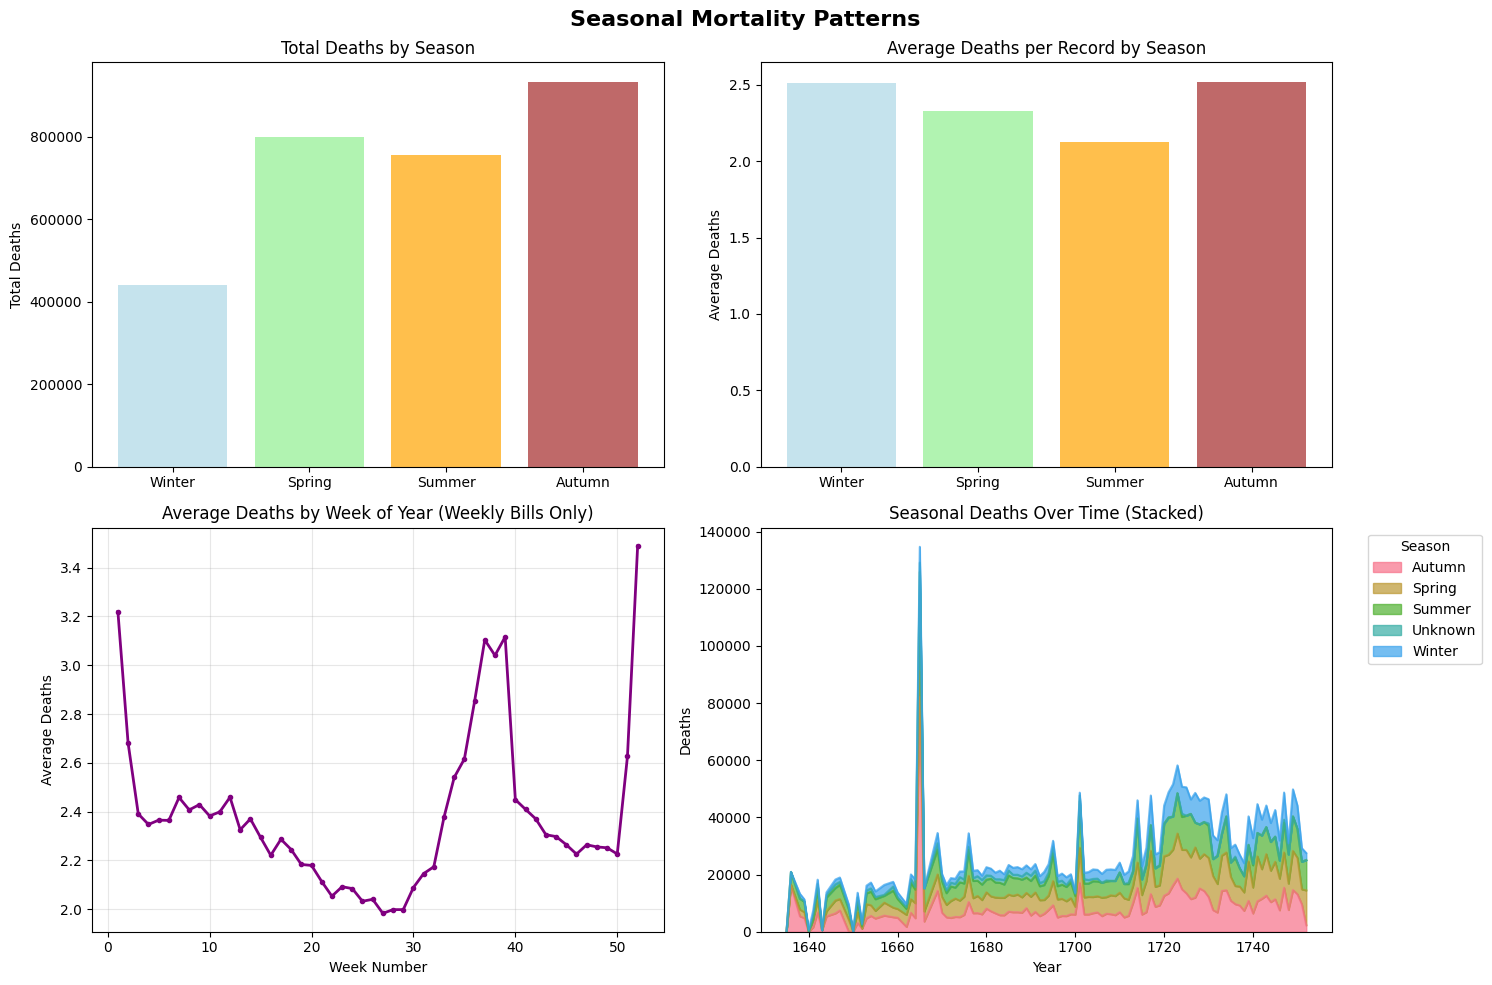


🌍 Seasonal Statistics:
  Winter: 439,856 total deaths, 2.5 avg per record, 174,846 records
  Spring: 799,368 total deaths, 2.3 avg per record, 342,791 records
  Summer: 755,131 total deaths, 2.1 avg per record, 355,658 records
  Autumn: 933,783 total deaths, 2.5 avg per record, 370,277 records

💀 Deadliest season: Autumn
🌱 Safest season: Winter


In [10]:
if 'season' in bills.columns:
    # Seasonal mortality patterns
    seasonal_totals = bills.groupby('season')['count'].agg(['sum', 'mean', 'count']).reset_index()
    seasonal_totals = seasonal_totals[seasonal_totals['season'] != 'Unknown']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Seasonal Mortality Patterns', fontsize=16, fontweight='bold')
    
    # Seasonal order
    season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
    seasonal_totals['season'] = pd.Categorical(seasonal_totals['season'], categories=season_order)
    seasonal_totals = seasonal_totals.sort_values('season')
    
    # Total deaths by season
    axes[0,0].bar(seasonal_totals['season'], seasonal_totals['sum'], 
                  color=['lightblue', 'lightgreen', 'orange', 'brown'], alpha=0.7)
    axes[0,0].set_title('Total Deaths by Season')
    axes[0,0].set_ylabel('Total Deaths')
    
    # Average deaths per record by season
    axes[0,1].bar(seasonal_totals['season'], seasonal_totals['mean'], 
                  color=['lightblue', 'lightgreen', 'orange', 'brown'], alpha=0.7)
    axes[0,1].set_title('Average Deaths per Record by Season')
    axes[0,1].set_ylabel('Average Deaths')
    
    # Weekly pattern within year (filter out general bills - week 90)
    if 'week_num' in bills.columns:
        weekly_bills_only = bills[bills['week_num'] <= 52]  # Filter out week 90 (general bills)
        weekly_avg = weekly_bills_only.groupby('week_num')['count'].mean()
        axes[1,0].plot(weekly_avg.index, weekly_avg.values, 
                       marker='o', linewidth=2, markersize=3, color='purple')
        axes[1,0].set_title('Average Deaths by Week of Year (Weekly Bills Only)')
        axes[1,0].set_xlabel('Week Number')
        axes[1,0].set_ylabel('Average Deaths')
        axes[1,0].grid(True, alpha=0.3)
        
        # Seasonal variation over time
        seasonal_by_year = bills.groupby(['year', 'season'])['count'].sum().unstack('season', fill_value=0)
        seasonal_by_year.plot(kind='area', stacked=True, ax=axes[1,1], alpha=0.7)
        axes[1,1].set_title('Seasonal Deaths Over Time (Stacked)')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Deaths')
        axes[1,1].legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Seasonal statistics
    print(f"\n🌍 Seasonal Statistics:")
    for _, row in seasonal_totals.iterrows():
        print(f"  {row['season']}: {row['sum']:,} total deaths, {row['mean']:.1f} avg per record, {row['count']:,} records")
        
    # Find deadliest season
    deadliest_season = seasonal_totals.loc[seasonal_totals['sum'].idxmax(), 'season']
    safest_season = seasonal_totals.loc[seasonal_totals['sum'].idxmin(), 'season']
    print(f"\n💀 Deadliest season: {deadliest_season}")
    print(f"🌱 Safest season: {safest_season}")

## Count Type Analysis Over Time

📋 Count types in dataset: ['buried' 'plague']


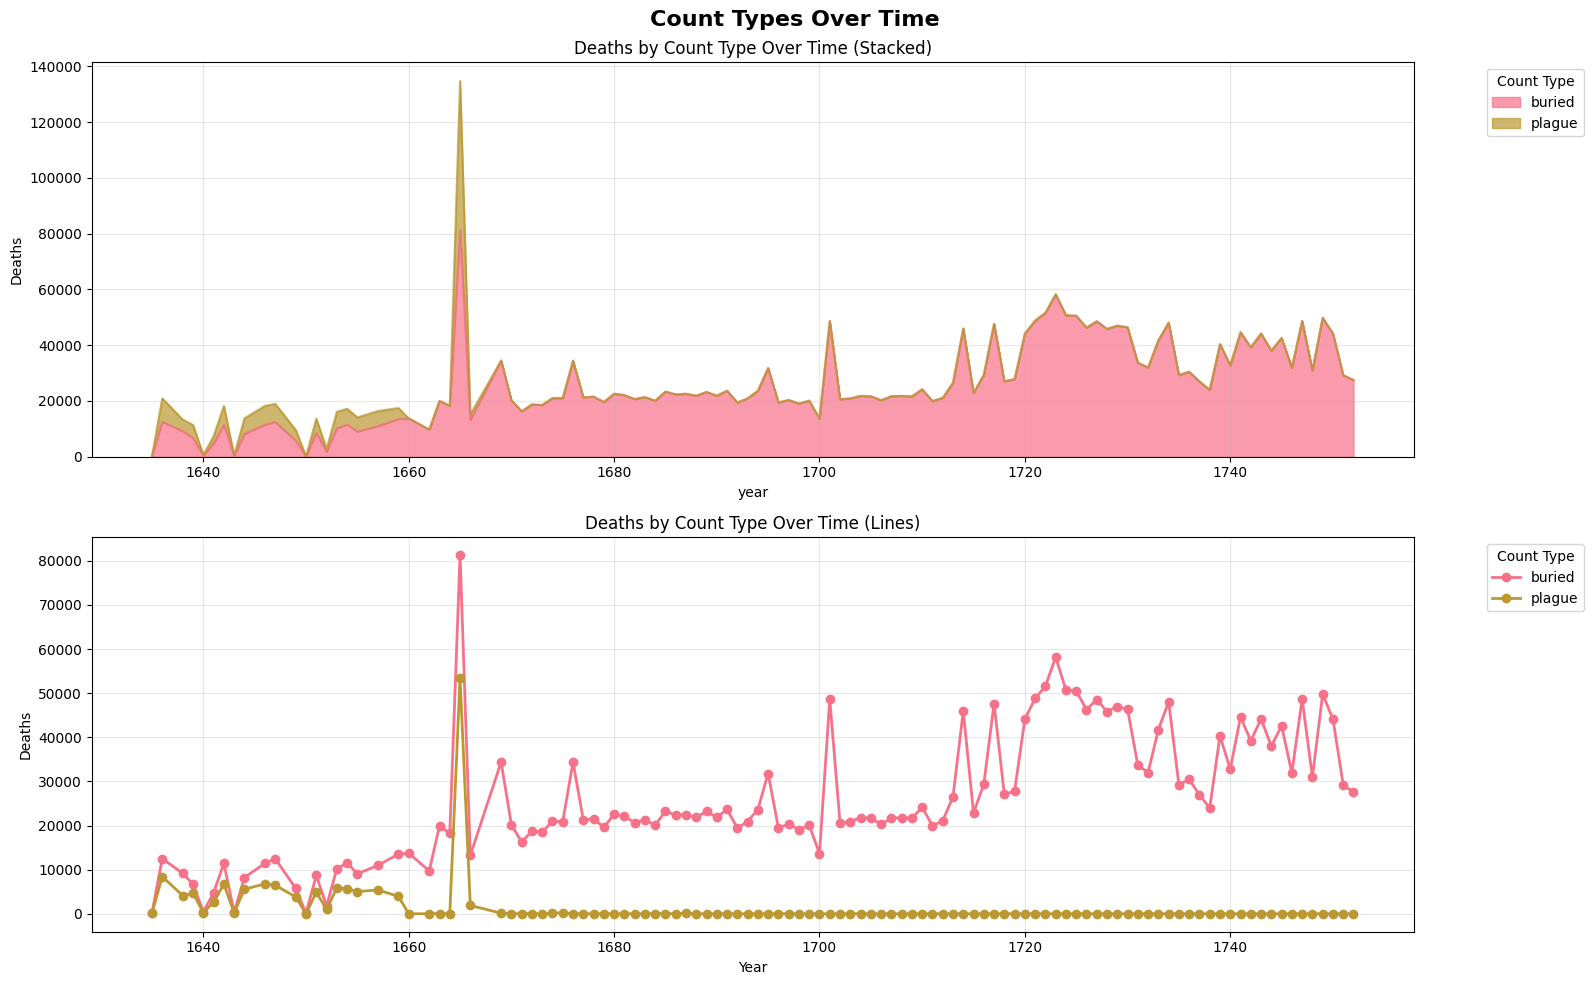


📊 Count Type Statistics:
                sum      mean   count
count_type                           
buried      2865621  3.072179  932765
plague       137975  0.383476  359801


In [12]:
# Count types over time
count_types = bills['count_type'].unique()
print(f"📋 Count types in dataset: {count_types}")

if len(count_types) > 1:
    # Multi-count type analysis
    count_by_type_year = bills.groupby(['year', 'count_type'])['count'].sum().unstack('count_type', fill_value=0)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('Count Types Over Time', fontsize=16, fontweight='bold')
    
    # Stacked area chart
    count_by_type_year.plot(kind='area', stacked=True, ax=axes[0], alpha=0.7)
    axes[0].set_title('Deaths by Count Type Over Time (Stacked)')
    axes[0].set_ylabel('Deaths')
    axes[0].legend(title='Count Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Line chart for comparison
    count_by_type_year.plot(kind='line', ax=axes[1], marker='o', linewidth=2)
    axes[1].set_title('Deaths by Count Type Over Time (Lines)')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Deaths')
    axes[1].legend(title='Count Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Count type statistics
    count_type_stats = bills.groupby('count_type')['count'].agg(['sum', 'mean', 'count'])
    print(f"\n📊 Count Type Statistics:")
    print(count_type_stats)
    
else:
    print(f"\n📝 Dataset contains only one count type: {count_types[0]}")
    
    # Focus on parish-level variation for single count type
    parish_yearly = bills.groupby(['year', 'parish_id'])['count'].sum().unstack('parish_id', fill_value=0)
    
    # Plot top 10 parishes by total deaths
    parish_totals = parish_yearly.sum().sort_values(ascending=False).head(10)
    top_parishes = parish_yearly[parish_totals.index]
    
    plt.figure(figsize=(16, 8))
    for parish_id in top_parishes.columns:
        parish_name = parish_map.get(parish_id, f'Parish {parish_id}')
        plt.plot(top_parishes.index, top_parishes[parish_id], 
                marker='o', linewidth=2, label=f'{parish_name[:20]}', alpha=0.8)
    
    plt.title('Deaths Over Time - Top 10 Parishes')
    plt.xlabel('Year')
    plt.ylabel('Deaths')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Crisis Detection and Analysis

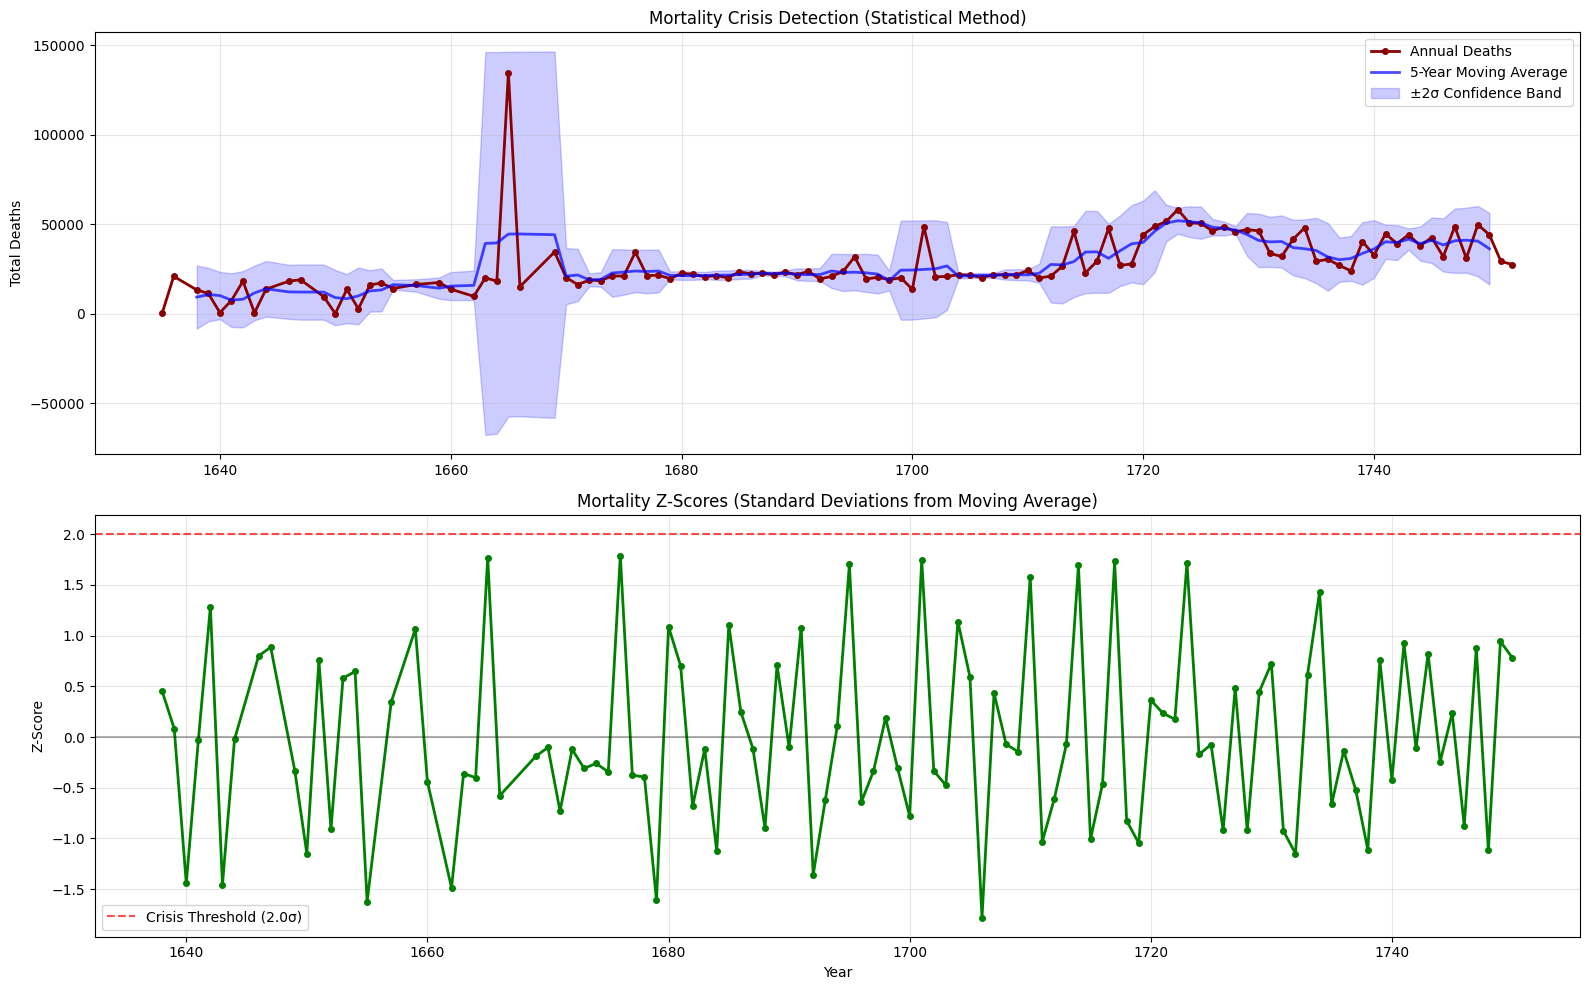


🚨 Statistical Crisis Years (>2.0σ above average):
  No statistical crises detected with threshold 2.0σ


In [15]:
# Crisis detection using statistical methods
yearly_totals_clean = yearly_totals.dropna(subset=['count'])

# Calculate moving average and standard deviation
window = 5  # 5-year window
yearly_totals_clean['moving_avg'] = yearly_totals_clean['count'].rolling(window=window, center=True).mean()
yearly_totals_clean['moving_std'] = yearly_totals_clean['count'].rolling(window=window, center=True).std()

# Define crisis as years exceeding 2 standard deviations above moving average
yearly_totals_clean['z_score'] = (yearly_totals_clean['count'] - yearly_totals_clean['moving_avg']) / yearly_totals_clean['moving_std']
crisis_threshold = 2.0
statistical_crises = yearly_totals_clean[yearly_totals_clean['z_score'] > crisis_threshold]

plt.figure(figsize=(16, 10))

# Main plot
plt.subplot(2, 1, 1)
plt.plot(yearly_totals_clean['year'], yearly_totals_clean['count'], 
         'o-', linewidth=2, markersize=4, color='darkred', label='Annual Deaths')
plt.plot(yearly_totals_clean['year'], yearly_totals_clean['moving_avg'], 
         '-', linewidth=2, color='blue', alpha=0.7, label=f'{window}-Year Moving Average')

# Add confidence bands
upper_band = yearly_totals_clean['moving_avg'] + 2 * yearly_totals_clean['moving_std']
lower_band = yearly_totals_clean['moving_avg'] - 2 * yearly_totals_clean['moving_std']
plt.fill_between(yearly_totals_clean['year'], lower_band, upper_band, 
                 alpha=0.2, color='blue', label='±2σ Confidence Band')

# Mark crisis years
for _, crisis in statistical_crises.iterrows():
    plt.axvline(x=crisis['year'], color='red', linestyle='--', alpha=0.7)
    plt.text(crisis['year'], crisis['count'], f"{crisis['year']}", 
             rotation=90, verticalalignment='bottom', fontsize=8)

plt.title('Mortality Crisis Detection (Statistical Method)')
plt.ylabel('Total Deaths')
plt.legend()
plt.grid(True, alpha=0.3)

# Z-score plot
plt.subplot(2, 1, 2)
plt.plot(yearly_totals_clean['year'], yearly_totals_clean['z_score'], 
         'o-', linewidth=2, markersize=4, color='green')
plt.axhline(y=crisis_threshold, color='red', linestyle='--', alpha=0.7, label=f'Crisis Threshold ({crisis_threshold}σ)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Mark crisis years
for _, crisis in statistical_crises.iterrows():
    plt.axvline(x=crisis['year'], color='red', linestyle='--', alpha=0.7)

plt.title('Mortality Z-Scores (Standard Deviations from Moving Average)')
plt.xlabel('Year')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Crisis summary
print(f"\n🚨 Statistical Crisis Years (>{crisis_threshold}σ above average):")
if len(statistical_crises) > 0:
    for _, crisis in statistical_crises.iterrows():
        print(f"  {crisis['year']}: {crisis['count']:,} deaths (Z-score: {crisis['z_score']:.2f})")
        
    # Calculate crisis frequency
    total_years = len(yearly_totals_clean)
    crisis_frequency = len(statistical_crises) / total_years * 100
    print(f"\n📈 Crisis frequency: {len(statistical_crises)} crises in {total_years} years ({crisis_frequency:.1f}%)")
    
    # Average crisis mortality
    avg_crisis_mortality = statistical_crises['count'].mean()
    avg_normal_mortality = yearly_totals_clean[yearly_totals_clean['z_score'] <= crisis_threshold]['count'].mean()
    crisis_multiplier = avg_crisis_mortality / avg_normal_mortality
    
    print(f"💀 Average crisis year mortality: {avg_crisis_mortality:,.0f} deaths")
    print(f"📊 Average normal year mortality: {avg_normal_mortality:,.0f} deaths")
    print(f"📈 Crisis mortality multiplier: {crisis_multiplier:.1f}x normal")
else:
    print(f"  No statistical crises detected with threshold {crisis_threshold}σ")

## Interactive Time Series (Plotly)

In [13]:
# Create interactive plot with Plotly
try:
    # Prepare data for interactive plot
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Total Deaths Over Time', 'Average Deaths per Record'),
        vertical_spacing=0.1
    )
    
    # Total deaths
    fig.add_trace(
        go.Scatter(
            x=yearly_totals['year'],
            y=yearly_totals['count'],
            mode='lines+markers',
            name='Total Deaths',
            line=dict(color='darkred', width=3),
            marker=dict(size=6),
            hovertemplate='<b>Year: %{x}</b><br>Deaths: %{y:,}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Average deaths
    fig.add_trace(
        go.Scatter(
            x=yearly_avg['year'],
            y=yearly_avg['count'],
            mode='lines+markers',
            name='Average Deaths per Record',
            line=dict(color='steelblue', width=3),
            marker=dict(size=6),
            hovertemplate='<b>Year: %{x}</b><br>Avg: %{y:.2f}<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Mark crisis years
    if len(statistical_crises) > 0:
        for _, crisis in statistical_crises.iterrows():
            fig.add_vline(
                x=crisis['year'],
                line_dash="dash",
                line_color="red",
                opacity=0.7,
                annotation_text=f"Crisis {crisis['year']}",
                annotation_position="top"
            )
    
    fig.update_layout(
        title='Bills of Mortality - Interactive Time Series',
        height=700,
        showlegend=True
    )
    
    fig.update_xaxes(title_text="Year")
    fig.update_yaxes(title_text="Deaths", row=1, col=1)
    fig.update_yaxes(title_text="Average Deaths", row=2, col=1)
    
    fig.show()
    
    print("\n📊 Interactive plot created! Use the controls to zoom and explore.")
    
except ImportError:
    print("\n📝 Note: Install plotly for interactive visualizations: pip install plotly")
except Exception as e:
    print(f"\n⚠️ Interactive plot error: {e}")


⚠️ Interactive plot error: name 'statistical_crises' is not defined


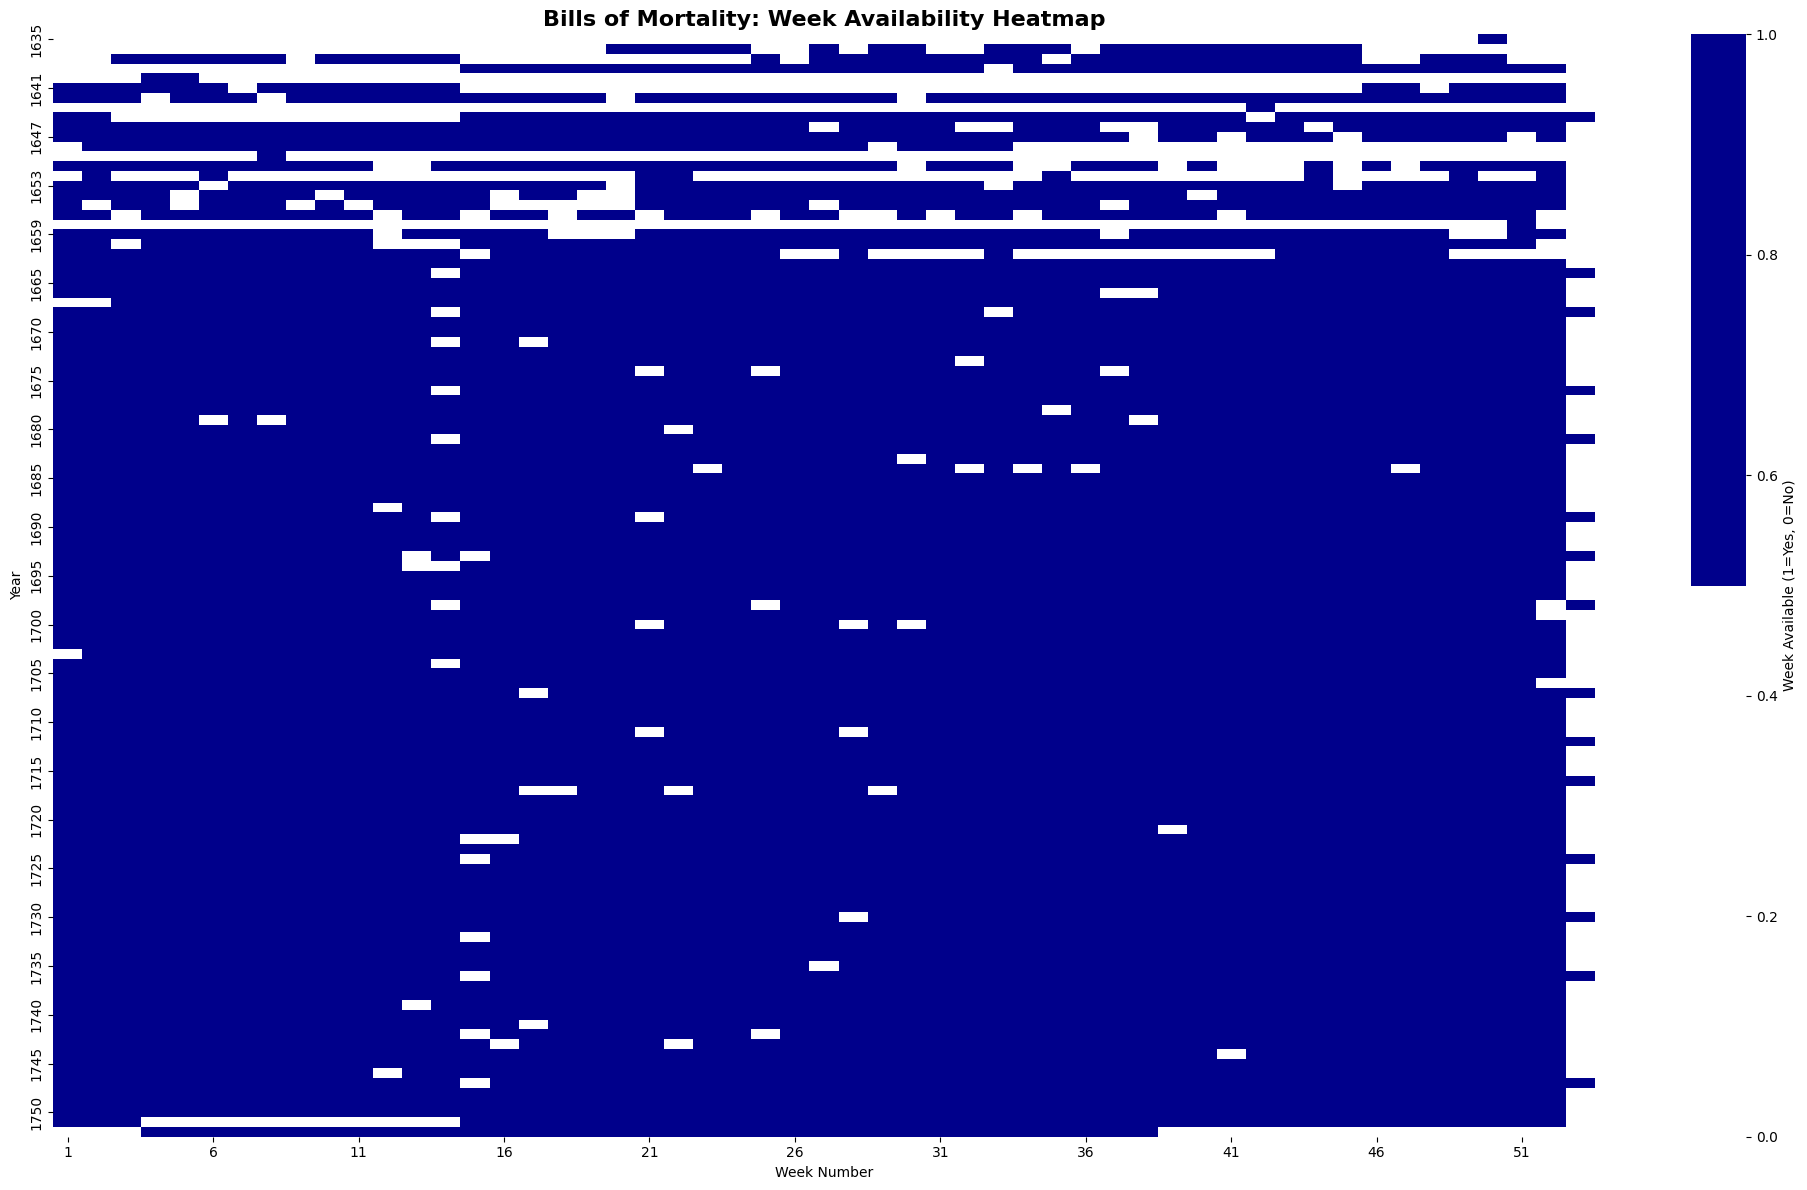

📊 Week Availability Heatmap created!
• Dark blue = week transcribed, White = week missing

🌍 Seasonal Coverage Patterns:
  • Winter (Weeks 1-12, 45-52): 89.8% of years have data
  • Spring (Weeks 13-25): 88.5% of years have data
  • Summer (Weeks 26-38): 89.8% of years have data
  • Autumn (Weeks 39-44): 90.1% of years have data

📈 Most Documented Weeks:
  • Week 24: 92.9% of years
  • Week 23: 92.0% of years
  • Week 44: 92.0% of years
  • Week 4: 91.2% of years
  • Week 22: 91.2% of years

📉 Least Documented Weeks:
  • Week 53: 13.3% of years
  • Week 14: 82.3% of years
  • Week 15: 84.1% of years
  • Week 12: 85.8% of years
  • Week 13: 86.7% of years


In [21]:
# Create a heatmap showing which specific weeks are available for each year
try:
    # Create a pivot table for week availability heatmap
    week_availability = weeks.pivot_table(
        index='year', 
        columns='week_number', 
        values='unique_identifier', 
        aggfunc='count', 
        fill_value=0
    )
    
    # Convert to binary (available/not available)
    week_availability_binary = (week_availability > 0).astype(int)
    
    # Create the heatmap
    plt.figure(figsize=(20, 12))
    sns.heatmap(week_availability_binary, 
                cmap=['white', 'darkblue'], 
                cbar_kws={'label': 'Week Available (1=Yes, 0=No)'}, 
                xticklabels=5,  # Show every 5th week number
                yticklabels=5)  # Show every 5th year
    
    plt.title('Bills of Mortality: Week Availability Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Week Number')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()
    
    print("📊 Week Availability Heatmap created!")
    print("• Dark blue = week transcribed, White = week missing")
    
    # Analyze seasonal patterns in missing data
    week_availability_pct = week_availability_binary.mean(axis=0) * 100
    
    # Define seasons by week number
    seasonal_coverage = {
        'Winter (Weeks 1-12, 45-52)': week_availability_pct[list(range(1, 13)) + list(range(45, 53))].mean(),
        'Spring (Weeks 13-25)': week_availability_pct[range(13, 26)].mean(),
        'Summer (Weeks 26-38)': week_availability_pct[range(26, 39)].mean(),
        'Autumn (Weeks 39-44)': week_availability_pct[range(39, 45)].mean()
    }
    
    print(f"\n🌍 Seasonal Coverage Patterns:")
    for season, coverage in seasonal_coverage.items():
        print(f"  • {season}: {coverage:.1f}% of years have data")
    
    # Find the most and least documented weeks
    best_weeks = week_availability_pct.nlargest(5)
    worst_weeks = week_availability_pct.nsmallest(5)
    
    print(f"\n📈 Most Documented Weeks:")
    for week, pct in best_weeks.items():
        print(f"  • Week {week}: {pct:.1f}% of years")
    
    print(f"\n📉 Least Documented Weeks:")
    for week, pct in worst_weeks.items():
        print(f"  • Week {week}: {pct:.1f}% of years")
        
except Exception as e:
    print(f"⚠️ Heatmap creation failed: {e}")
    print("This might be due to memory constraints with large datasets.")

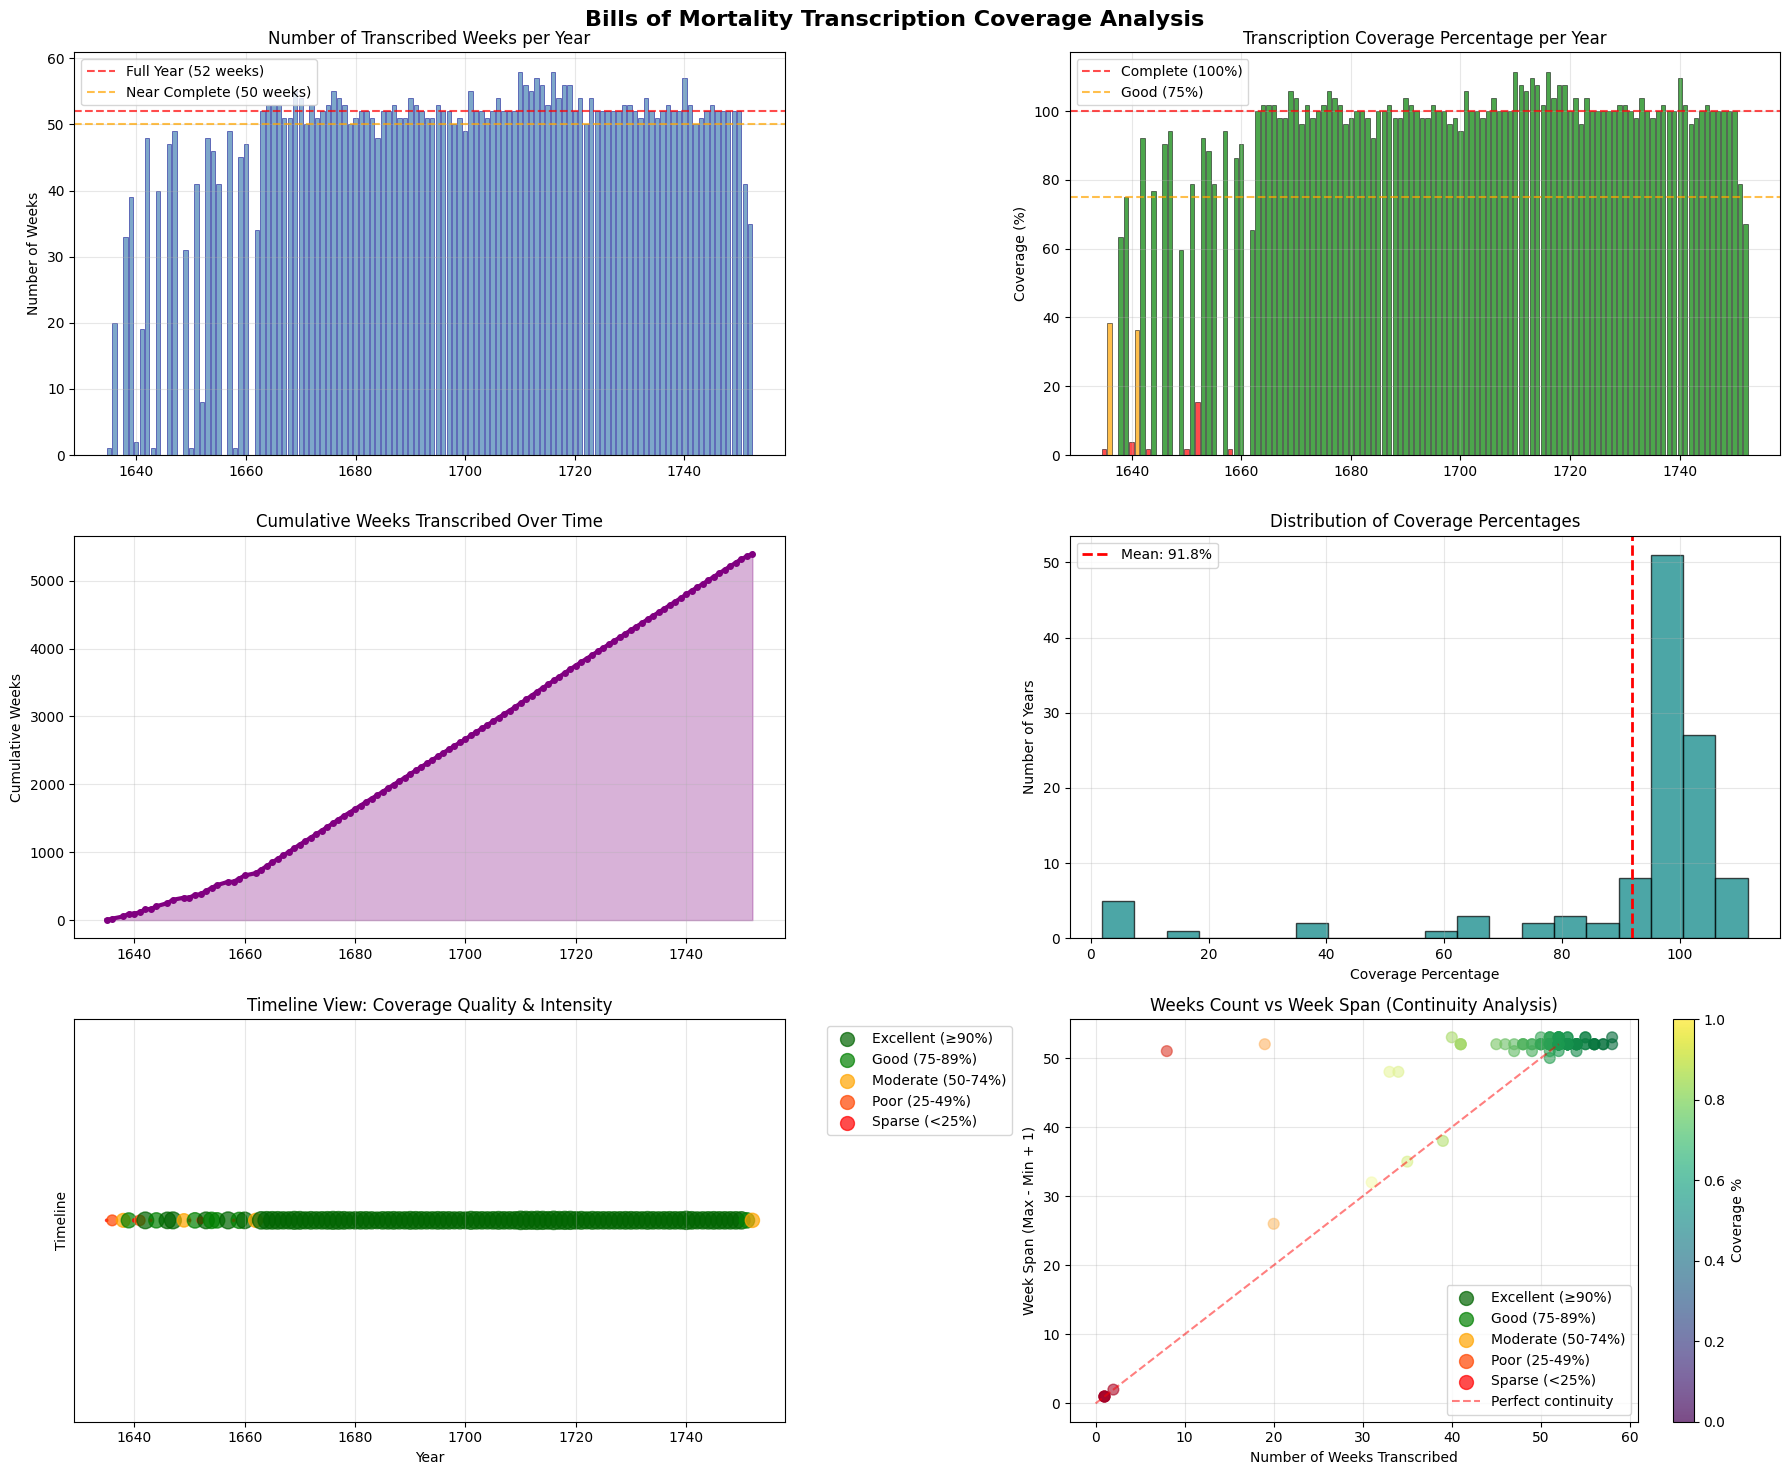


📊 Continuity Analysis:
  • Years with perfect continuity: 35 (31.0%)
  • Years with large gaps (>10 weeks): 8
    - 1638.0: 33.0 weeks across 48.0 week span (gap: 15.0)
    - 1641.0: 19.0 weeks across 52.0 week span (gap: 33.0)
    - 1644.0: 40.0 weeks across 53.0 week span (gap: 13.0)
    - 1651.0: 41.0 weeks across 52.0 week span (gap: 11.0)
    - 1652.0: 8.0 weeks across 51.0 week span (gap: 43.0)
    - 1655.0: 41.0 weeks across 52.0 week span (gap: 11.0)
    - 1662.0: 34.0 weeks across 48.0 week span (gap: 14.0)
    - 1751.0: 41.0 weeks across 52.0 week span (gap: 11.0)

📅 Coverage by Decade:
  • 1630s: 23.2 avg weeks (44.7% coverage) across 4.0 years
  • 1640s: 29.6 avg weeks (57.0% coverage) across 8.0 years
  • 1650s: 31.1 avg weeks (59.8% coverage) across 9.0 years
  • 1660s: 49.9 avg weeks (95.9% coverage) across 9.0 years
  • 1670s: 52.5 avg weeks (101.0% coverage) across 10.0 years
  • 1680s: 51.3 avg weeks (98.7% coverage) across 10.0 years
  • 1690s: 51.9 avg weeks (99.8%

In [24]:
# Create comprehensive transcription coverage visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Bills of Mortality Transcription Coverage Analysis', fontsize=16, fontweight='bold')

# 1. Weeks per year bar chart
axes[0,0].bar(weeks_per_year['year'], weeks_per_year['weeks_count'], 
              alpha=0.7, color='steelblue', edgecolor='darkblue', linewidth=0.5)
axes[0,0].axhline(y=52, color='red', linestyle='--', alpha=0.7, label='Full Year (52 weeks)')
axes[0,0].axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Near Complete (50 weeks)')
axes[0,0].set_title('Number of Transcribed Weeks per Year')
axes[0,0].set_ylabel('Number of Weeks')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Coverage percentage
color_map = ['red' if x < 20 else 'orange' if x < 50 else 'green' for x in weeks_per_year['coverage_pct']]
axes[0,1].bar(weeks_per_year['year'], weeks_per_year['coverage_pct'], 
              alpha=0.7, color=color_map, edgecolor='black', linewidth=0.5)
axes[0,1].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Complete (100%)')
axes[0,1].axhline(y=75, color='orange', linestyle='--', alpha=0.7, label='Good (75%)')
axes[0,1].set_title('Transcription Coverage Percentage per Year')
axes[0,1].set_ylabel('Coverage (%)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Cumulative weeks over time
weeks_per_year['cumulative_weeks'] = weeks_per_year['weeks_count'].cumsum()
axes[1,0].plot(weeks_per_year['year'], weeks_per_year['cumulative_weeks'], 
               marker='o', linewidth=3, markersize=4, color='purple')
axes[1,0].fill_between(weeks_per_year['year'], weeks_per_year['cumulative_weeks'], alpha=0.3, color='purple')
axes[1,0].set_title('Cumulative Weeks Transcribed Over Time')
axes[1,0].set_ylabel('Cumulative Weeks')
axes[1,0].grid(True, alpha=0.3)

# 4. Coverage distribution histogram
axes[1,1].hist(weeks_per_year['coverage_pct'], bins=20, alpha=0.7, color='teal', edgecolor='black')
axes[1,1].axvline(x=avg_coverage, color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {avg_coverage:.1f}%')
axes[1,1].set_title('Distribution of Coverage Percentages')
axes[1,1].set_xlabel('Coverage Percentage')
axes[1,1].set_ylabel('Number of Years')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 5. Timeline view with coverage quality
coverage_colors = []
for pct in weeks_per_year['coverage_pct']:
    if pct >= 90: coverage_colors.append('darkgreen')
    elif pct >= 75: coverage_colors.append('green') 
    elif pct >= 50: coverage_colors.append('orange')
    elif pct >= 25: coverage_colors.append('orangered')
    else: coverage_colors.append('red')

axes[2,0].scatter(weeks_per_year['year'], [1]*len(weeks_per_year), 
                  c=coverage_colors, s=weeks_per_year['weeks_count']*3, alpha=0.7)
axes[2,0].set_title('Timeline View: Coverage Quality & Intensity')
axes[2,0].set_xlabel('Year')
axes[2,0].set_ylabel('Timeline')
axes[2,0].set_yticks([])
axes[2,0].grid(True, alpha=0.3)

# Create custom legend for timeline
legend_elements = [
    plt.scatter([], [], c='darkgreen', s=100, alpha=0.7, label='Excellent (≥90%)'),
    plt.scatter([], [], c='green', s=100, alpha=0.7, label='Good (75-89%)'),
    plt.scatter([], [], c='orange', s=100, alpha=0.7, label='Moderate (50-74%)'),
    plt.scatter([], [], c='orangered', s=100, alpha=0.7, label='Poor (25-49%)'),
    plt.scatter([], [], c='red', s=100, alpha=0.7, label='Sparse (<25%)')
]
axes[2,0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

# 6. Week span analysis (continuity)
axes[2,1].scatter(weeks_per_year['weeks_count'], weeks_per_year['week_span'], 
                  alpha=0.6, s=60, c=weeks_per_year['coverage_pct'], cmap='RdYlGn')
axes[2,1].plot([0, 52], [0, 52], 'r--', alpha=0.5, label='Perfect continuity')
axes[2,1].set_title('Weeks Count vs Week Span (Continuity Analysis)')
axes[2,1].set_xlabel('Number of Weeks Transcribed')
axes[2,1].set_ylabel('Week Span (Max - Min + 1)')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# Add colorbar for the scatter plot
cbar = plt.colorbar(axes[2,1].collections[0], ax=axes[2,1])
cbar.set_label('Coverage %')

plt.tight_layout()
plt.show()

# Additional analysis: gaps and continuity
print(f"\n📊 Continuity Analysis:")
perfect_continuity = weeks_per_year[weeks_per_year['weeks_count'] == weeks_per_year['week_span']]
print(f"  • Years with perfect continuity: {len(perfect_continuity)} ({len(perfect_continuity)/len(weeks_per_year)*100:.1f}%)")

# Years with large gaps
large_gaps = weeks_per_year[weeks_per_year['week_span'] - weeks_per_year['weeks_count'] > 10]
if len(large_gaps) > 0:
    print(f"  • Years with large gaps (>10 weeks): {len(large_gaps)}")
    for _, row in large_gaps.head(10).iterrows():
        gap_size = row['week_span'] - row['weeks_count']
        print(f"    - {row['year']}: {row['weeks_count']} weeks across {row['week_span']} week span (gap: {gap_size})")

# Decade analysis
weeks_per_year['decade'] = (weeks_per_year['year'] // 10) * 10
decade_coverage = weeks_per_year.groupby('decade').agg({
    'weeks_count': 'mean',
    'coverage_pct': 'mean',
    'year': 'count'
}).round(1)
decade_coverage.columns = ['avg_weeks', 'avg_coverage_pct', 'years_count']

print(f"\n📅 Coverage by Decade:")
for decade, row in decade_coverage.iterrows():
    print(f"  • {decade}s: {row['avg_weeks']} avg weeks ({row['avg_coverage_pct']}% coverage) across {row['years_count']} years")

In [23]:
# Analyze transcription coverage by examining weeks per year
print("📅 Transcription Coverage Analysis")
print("="*40)

# Load weeks data to analyze coverage
weeks_df = pd.read_csv(DATA_DIR / 'weeks.csv')

# Calculate weeks per year
weeks_per_year = weeks_df.groupby('year').agg({
    'week_number': ['count', 'min', 'max'],
    'unique_identifier': 'count'
}).round(2)

# Flatten column names
weeks_per_year.columns = ['weeks_count', 'min_week', 'max_week', 'total_records']
weeks_per_year = weeks_per_year.reset_index()

# Calculate coverage statistics
weeks_per_year['coverage_pct'] = (weeks_per_year['weeks_count'] / 52 * 100).round(1)
weeks_per_year['week_span'] = weeks_per_year['max_week'] - weeks_per_year['min_week'] + 1

print(f"📊 Dataset spans {weeks_per_year['year'].min()} - {weeks_per_year['year'].max()}")
print(f"📈 Total years with data: {len(weeks_per_year)}")
print(f"📅 Total unique weeks: {weeks_df['week_number'].nunique()}")
print(f"📋 Total week records: {len(weeks_df):,}")

# Summary statistics
full_years = weeks_per_year[weeks_per_year['weeks_count'] >= 50]  # Near-complete years
partial_years = weeks_per_year[weeks_per_year['weeks_count'] < 20]  # Sparse years
moderate_years = weeks_per_year[(weeks_per_year['weeks_count'] >= 20) & (weeks_per_year['weeks_count'] < 50)]

print(f"\n📈 Coverage Summary:")
print(f"  • Full coverage (≥50 weeks): {len(full_years)} years ({len(full_years)/len(weeks_per_year)*100:.1f}%)")
print(f"  • Moderate coverage (20-49 weeks): {len(moderate_years)} years ({len(moderate_years)/len(weeks_per_year)*100:.1f}%)")
print(f"  • Sparse coverage (<20 weeks): {len(partial_years)} years ({len(partial_years)/len(weeks_per_year)*100:.1f}%)")

avg_coverage = weeks_per_year['coverage_pct'].mean()
print(f"  • Average coverage: {avg_coverage:.1f}% of weeks per year")

# Identify best and worst covered years
best_years = weeks_per_year.nlargest(5, 'weeks_count')[['year', 'weeks_count', 'coverage_pct']]
worst_years = weeks_per_year.nsmallest(5, 'weeks_count')[['year', 'weeks_count', 'coverage_pct']]

print(f"\n🏆 Best Covered Years:")
for _, row in best_years.iterrows():
    print(f"  • {row['year']}: {row['weeks_count']} weeks ({row['coverage_pct']}%)")

print(f"\n⚠️ Sparsest Years:")
for _, row in worst_years.iterrows():
    print(f"  • {row['year']}: {row['weeks_count']} weeks ({row['coverage_pct']}%)")

📅 Transcription Coverage Analysis
📊 Dataset spans 1635 - 1752
📈 Total years with data: 113
📅 Total unique weeks: 53
📋 Total week records: 5,393

📈 Coverage Summary:
  • Full coverage (≥50 weeks): 86 years (76.1%)
  • Moderate coverage (20-49 weeks): 20 years (17.7%)
  • Sparse coverage (<20 weeks): 7 years (6.2%)
  • Average coverage: 91.8% of weeks per year

🏆 Best Covered Years:
  • 1710.0: 58.0 weeks (111.5%)
  • 1716.0: 58.0 weeks (111.5%)
  • 1713.0: 57.0 weeks (109.6%)
  • 1740.0: 57.0 weeks (109.6%)
  • 1711.0: 56.0 weeks (107.7%)

⚠️ Sparsest Years:
  • 1635.0: 1.0 weeks (1.9%)
  • 1643.0: 1.0 weeks (1.9%)
  • 1650.0: 1.0 weeks (1.9%)
  • 1658.0: 1.0 weeks (1.9%)
  • 1640.0: 2.0 weeks (3.8%)


## Transcription Coverage Analysis

This section analyzes the completeness of the digitized Bills of Mortality dataset by examining the number of weeks transcribed per year.

In [ ]:
# Analyze bill types in current dataset
print("📋 Bill Type Analysis")
print("="*40)

# Check bill_type distribution
bill_type_counts = bills['bill_type'].value_counts()
print(f"Bill types in dataset:")
for bill_type, count in bill_type_counts.items():
    pct = count / len(bills) * 100
    print(f"  • {bill_type}: {count:,} records ({pct:.1f}%)")

# Check for general bills by week number analysis
if 'week_num' in bills.columns:
    week_dist = bills['week_num'].value_counts().sort_index()
    max_week = bills['week_num'].max()
    print(f"\nWeek number range: 1 - {max_week}")
    
    # Look for potential general bills (week 90 or other unusual week numbers)
    unusual_weeks = bills[bills['week_num'] > 52] if 'week_num' in bills.columns else pd.DataFrame()
    
    if len(unusual_weeks) > 0:
        print(f"Records with week numbers >52 (potential general bills): {len(unusual_weeks)}")
        unusual_week_dist = unusual_weeks['week_num'].value_counts().sort_index()
        for week, count in unusual_week_dist.items():
            print(f"  • Week {week}: {count} records")
    else:
        print("⚠️  No general bills found (no week numbers >52)")
        print("   General bills should appear as week 90 in complete datasets")

# Check unique identifiers for general bill patterns
identifier_patterns = bills['unique_identifier'].str.contains('general|General|GENERAL', case=False, na=False)
potential_general_bills = bills[identifier_patterns]

print(f"\nRecords with 'General' in identifier: {len(potential_general_bills)}")
if len(potential_general_bills) > 0:
    print(f"Sample general bill identifiers:")
    for identifier in potential_general_bills['unique_identifier'].unique()[:5]:
        print(f"  • {identifier}")

# Temporal distribution of bill types
if len(bill_type_counts) > 1:
    bill_type_by_year = bills.groupby(['year', 'bill_type']).size().unstack('bill_type', fill_value=0)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('Distribution of Bill Types Over Time', fontsize=16, fontweight='bold')
    
    # Stacked area chart
    bill_type_by_year.plot(kind='area', stacked=True, ax=axes[0], alpha=0.7)
    axes[0].set_title('Bill Types Over Time (Stacked)')
    axes[0].set_ylabel('Number of Records')
    axes[0].legend(title='Bill Type')
    axes[0].grid(True, alpha=0.3)
    
    # Line plot for comparison
    bill_type_by_year.plot(kind='line', ax=axes[1], marker='o', linewidth=2)
    axes[1].set_title('Bill Types Over Time (Lines)')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Number of Records')
    axes[1].legend(title='Bill Type')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"\n📊 Current dataset contains only: {bill_type_counts.index[0]} bills")
    
    # Create visualization showing the missing general bills issue
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Bills of Mortality: Weekly vs General Bills Analysis', fontsize=16, fontweight='bold')
    
    # Weekly bill distribution by year
    yearly_totals = bills.groupby('year').size()
    axes[0].bar(yearly_totals.index, yearly_totals.values, alpha=0.7, color='steelblue')
    axes[0].set_title('Weekly Bills per Year\n(General Bills Missing)')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Records')
    axes[0].grid(True, alpha=0.3)
    
    # Expected vs actual bill types
    expected_types = ['Weekly', 'General']
    expected_counts = [len(bills), 0]  # 0 general bills currently
    actual_counts = [len(bills[bills['bill_type'] == 'weekly']), 0]
    
    x = range(len(expected_types))
    width = 0.35
    
    axes[1].bar([i - width/2 for i in x], expected_counts, width, 
               label='Expected', alpha=0.7, color='lightgreen')
    axes[1].bar([i + width/2 for i in x], actual_counts, width, 
               label='Current Dataset', alpha=0.7, color='lightcoral')
    
    axes[1].set_title('Expected vs Actual Bill Types')
    axes[1].set_xlabel('Bill Type')
    axes[1].set_ylabel('Number of Records')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(expected_types)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Data completeness analysis
print(f"\n📈 Data Completeness Assessment:")
print(f"  • Total records in dataset: {len(bills):,}")
print(f"  • Years covered: {bills['year'].nunique()} ({bills['year'].min()}-{bills['year'].max()})")
print(f"  • Expected general bills: ~{bills['year'].nunique()} (one per year)")
print(f"  • Missing general bills: Likely ~{bills['year'].nunique()} records")

total_expected_with_general = len(bills) + bills['year'].nunique()
missing_pct = bills['year'].nunique() / total_expected_with_general * 100

print(f"  • Estimated missing data: ~{missing_pct:.1f}% of complete dataset")
print(f"\n⚠️  RECOMMENDATION: Integrate general bills data to achieve complete coverage")
print(f"   General bills files found in data-raw: *generalbills*.csv")

## General vs Weekly Bills Analysis

The Bills of Mortality came in two main types:
- **Weekly Bills**: Published weekly throughout the year (weeks 1-52)
- **General Bills**: Annual summaries published at year-end (should appear as week 90)

📊 General vs Weekly Bills Distribution
Updated dataset: 1,292,566 total records

Bill Type Distribution:
  • Weekly: 1,245,012 records (96.3%)
  • General: 47,554 records (3.7%)


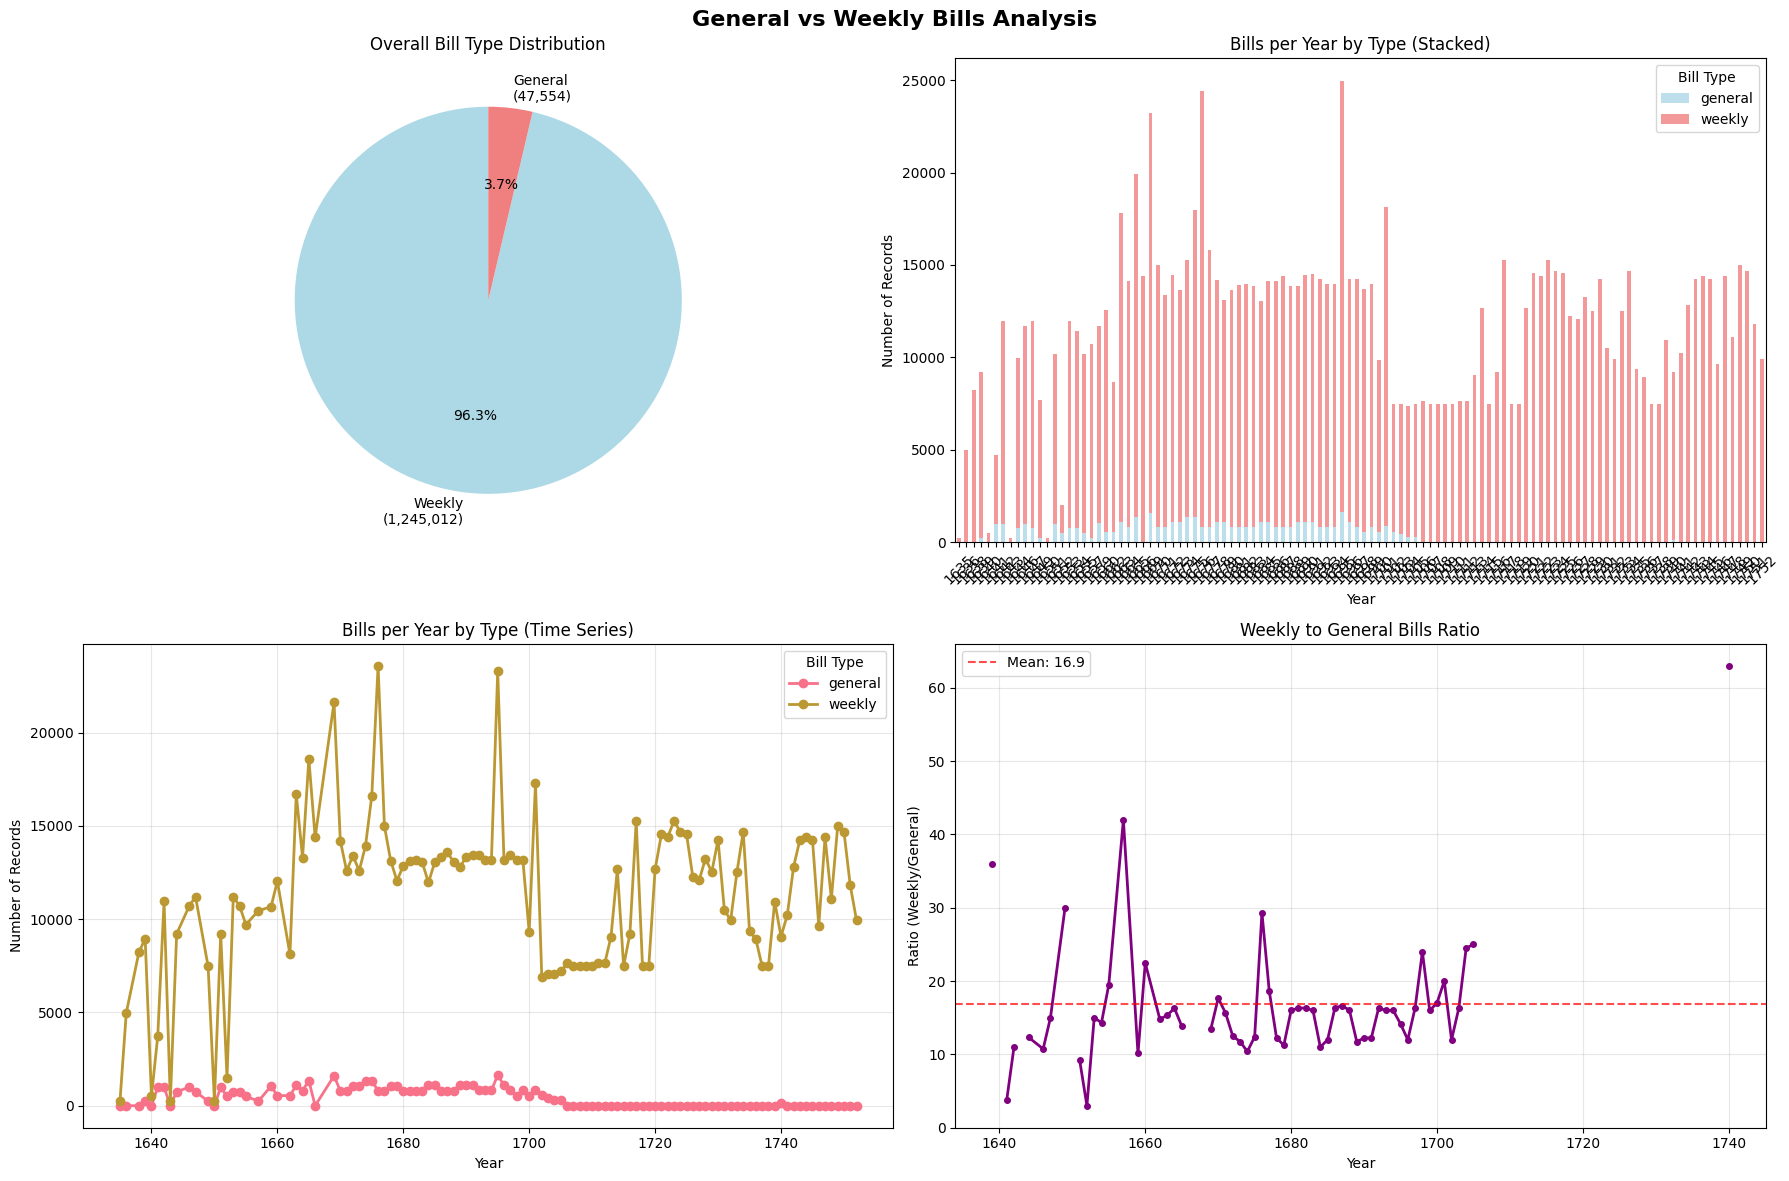


📈 Statistical Summary:
  • Years with both bill types: 57
  • Years with only weekly bills: 53
  • Years with only general bills: 0

📊 Weekly Bills Statistics:
  • Mean per year: 11318.3
  • Median per year: 12168.0
  • Range: 249 - 23584

📊 General Bills Statistics:
  • Mean per year: 432.3
  • Median per year: 249.0
  • Range: 0 - 1644

🔗 Correlation between weekly and general bills: 0.426


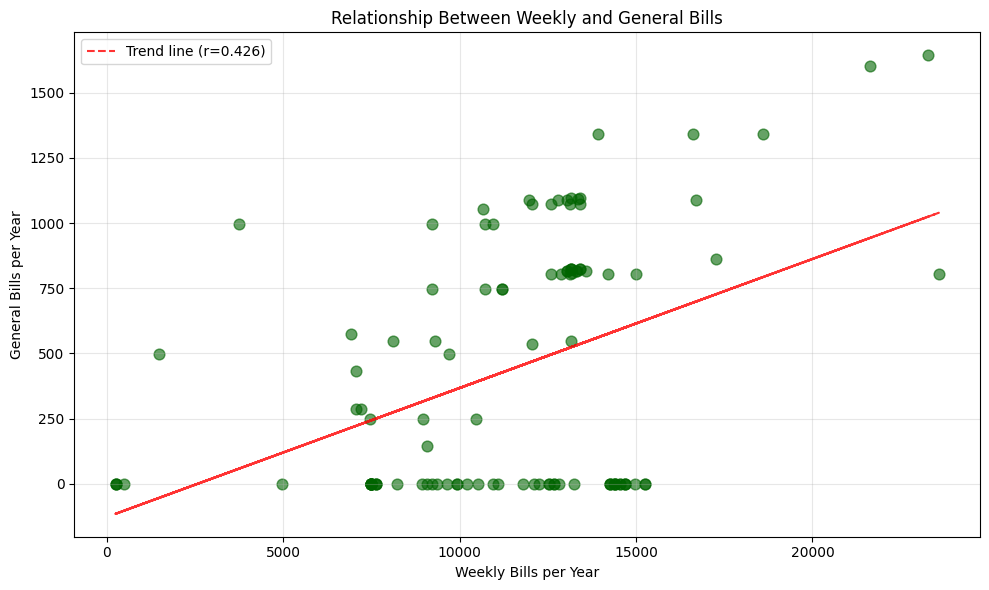


🎯 Data Completeness Assessment:
  • Total years in dataset: 110
  • Years with general bills: 57 (51.8%)
  • Expected general bills: 110 (one per year)
  • Years missing general bills: 53
    Sample missing years: [1635, 1636, 1638, 1640, 1643, 1650, 1666, 1706, 1707, 1708]...

📚 Historical Context:
  • General Bills were annual summaries published at year-end
  • They provided totals and often additional statistical information
  • Weekly Bills tracked ongoing mortality throughout the year
  • Both types are essential for complete demographic analysis

🔬 Research Implications:
  • Weekly bills enable temporal analysis within years
  • General bills provide annual totals and cross-validation
  • Combined analysis allows for comprehensive mortality studies
  • Missing general bills may indicate data collection gaps


In [16]:
# General vs Weekly Bills Distribution Analysis
print("📊 General vs Weekly Bills Distribution")
print("="*50)

# Load the updated data with general bills
bills_updated = pd.read_csv(DATA_DIR / 'all_bills.csv')
print(f"Updated dataset: {len(bills_updated):,} total records")

# Analyze bill type distribution
bill_type_dist = bills_updated['bill_type'].value_counts()
print(f"\nBill Type Distribution:")
for bill_type, count in bill_type_dist.items():
    pct = count / len(bills_updated) * 100
    print(f"  • {bill_type.title()}: {count:,} records ({pct:.1f}%)")

# Analyze by year
bill_types_by_year = bills_updated.groupby(['year', 'bill_type']).size().unstack('bill_type', fill_value=0)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('General vs Weekly Bills Analysis', fontsize=16, fontweight='bold')

# 1. Overall distribution pie chart
axes[0,0].pie(bill_type_dist.values, labels=[f'{k.title()}\n({v:,})' for k, v in bill_type_dist.items()], 
              autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0,0].set_title('Overall Bill Type Distribution')

# 2. Bills per year stacked
bill_types_by_year.plot(kind='bar', stacked=True, ax=axes[0,1], 
                       color=['lightblue', 'lightcoral'], alpha=0.8)
axes[0,1].set_title('Bills per Year by Type (Stacked)')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Number of Records')
axes[0,1].legend(title='Bill Type')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Time series comparison
bill_types_by_year.plot(kind='line', ax=axes[1,0], marker='o', linewidth=2)
axes[1,0].set_title('Bills per Year by Type (Time Series)')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Number of Records')
axes[1,0].legend(title='Bill Type')
axes[1,0].grid(True, alpha=0.3)

# 4. Weekly vs General ratio over time
if 'general' in bill_types_by_year.columns and 'weekly' in bill_types_by_year.columns:
    # Calculate ratio of weekly to general bills
    ratio_data = bill_types_by_year.copy()
    ratio_data['weekly_to_general_ratio'] = (ratio_data['weekly'] / ratio_data['general'].replace(0, np.nan))
    
    axes[1,1].plot(ratio_data.index, ratio_data['weekly_to_general_ratio'], 
                   'o-', color='purple', linewidth=2, markersize=4)
    axes[1,1].set_title('Weekly to General Bills Ratio')
    axes[1,1].set_xlabel('Year')
    axes[1,1].set_ylabel('Ratio (Weekly/General)')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add reference lines
    mean_ratio = ratio_data['weekly_to_general_ratio'].mean()
    axes[1,1].axhline(y=mean_ratio, color='red', linestyle='--', alpha=0.7, 
                      label=f'Mean: {mean_ratio:.1f}')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

# Statistical analysis
print(f"\n📈 Statistical Summary:")
print(f"  • Years with both bill types: {len(bill_types_by_year[(bill_types_by_year['weekly'] > 0) & (bill_types_by_year['general'] > 0)])}")
print(f"  • Years with only weekly bills: {len(bill_types_by_year[(bill_types_by_year['weekly'] > 0) & (bill_types_by_year['general'] == 0)])}")
print(f"  • Years with only general bills: {len(bill_types_by_year[(bill_types_by_year['weekly'] == 0) & (bill_types_by_year['general'] > 0)])}")

if 'general' in bill_types_by_year.columns and 'weekly' in bill_types_by_year.columns:
    weekly_stats = bill_types_by_year['weekly'].describe()
    general_stats = bill_types_by_year['general'].describe()
    
    print(f"\n📊 Weekly Bills Statistics:")
    print(f"  • Mean per year: {weekly_stats['mean']:.1f}")
    print(f"  • Median per year: {weekly_stats['50%']:.1f}")
    print(f"  • Range: {weekly_stats['min']:.0f} - {weekly_stats['max']:.0f}")
    
    print(f"\n📊 General Bills Statistics:")
    print(f"  • Mean per year: {general_stats['mean']:.1f}")
    print(f"  • Median per year: {general_stats['50%']:.1f}")
    print(f"  • Range: {general_stats['min']:.0f} - {general_stats['max']:.0f}")
    
    # Analyze the relationship between weekly and general bills
    correlation = bill_types_by_year['weekly'].corr(bill_types_by_year['general'])
    print(f"\n🔗 Correlation between weekly and general bills: {correlation:.3f}")
    
    # Create scatter plot to show relationship
    plt.figure(figsize=(10, 6))
    plt.scatter(bill_types_by_year['weekly'], bill_types_by_year['general'], 
                alpha=0.6, s=60, color='darkgreen')
    plt.xlabel('Weekly Bills per Year')
    plt.ylabel('General Bills per Year')
    plt.title('Relationship Between Weekly and General Bills')
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(bill_types_by_year['weekly'], bill_types_by_year['general'], 1)
    p = np.poly1d(z)
    plt.plot(bill_types_by_year['weekly'], p(bill_types_by_year['weekly']), 
             "r--", alpha=0.8, label=f'Trend line (r={correlation:.3f})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Coverage completeness analysis
print(f"\n🎯 Data Completeness Assessment:")
total_years = len(bill_types_by_year)
years_with_general = len(bill_types_by_year[bill_types_by_year['general'] > 0])
coverage_pct = years_with_general / total_years * 100

print(f"  • Total years in dataset: {total_years}")
print(f"  • Years with general bills: {years_with_general} ({coverage_pct:.1f}%)")
print(f"  • Expected general bills: {total_years} (one per year)")

if years_with_general < total_years:
    missing_years = bill_types_by_year[bill_types_by_year['general'] == 0].index.tolist()
    print(f"  • Years missing general bills: {len(missing_years)}")
    if len(missing_years) <= 10:
        print(f"    Missing years: {missing_years}")
    else:
        print(f"    Sample missing years: {missing_years[:10]}...")

# Historical context
print(f"\n📚 Historical Context:")
print(f"  • General Bills were annual summaries published at year-end")
print(f"  • They provided totals and often additional statistical information")
print(f"  • Weekly Bills tracked ongoing mortality throughout the year")
print(f"  • Both types are essential for complete demographic analysis")

# Research implications
print(f"\n🔬 Research Implications:")
print(f"  • Weekly bills enable temporal analysis within years")
print(f"  • General bills provide annual totals and cross-validation")
print(f"  • Combined analysis allows for comprehensive mortality studies")
print(f"  • Missing general bills may indicate data collection gaps")